In [23]:
import pypsa 
import atlite 
import vresutils.shapes as vshapes
from vresutils.graph import voronoi_partition_pts
import geopandas as gpd
import powerplantmatching as pm
import pandas as pd
from scipy.spatial import KDTree
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

# Build

In [4]:
n = pypsa.Network('original-model_original-data')
n.set_snapshots(pd.DatetimeIndex(start='2015', end='2017', closed='left', freq='h'))

INFO:pypsa.io:Imported network original-model_original-data has buses, carriers, generators, lines, loads


In [7]:
#drop generators
n.mremove('Generator', n.generators.index)
n.buses['substation_lv'] = True # assume all are substations

In [8]:
#add generators from pm 
pm.config.set_target_countries('Vietnam')
ppl = pm.data.WRI(filter_other_dbs=False) #could also match with pm.data.CARMA()
#assume all hydro are rors
ppl, ror  = ppl[ppl.Fueltype != 'Hydro'], ppl[ppl.Fueltype == 'Hydro'] 
pm.export.to_pypsa_network(ppl, n)

AttributeError: 'module' object has no attribute 'set_target_countries'

In [22]:
vietshape = vshapes.countries(subset=['VN'])['VN']
onshore_locs = n.buses.loc[:, ["x", "y"]]
regions = gpd.GeoDataFrame({
                            'geometry': voronoi_partition_pts(onshore_locs.values, vietshape),
                            'country': 'VN'}, index=onshore_locs.index).rename_axis('bus')

Serving call to countries from file vresutils.shapes.countries_ver3__subset.VN.pickle of cache: 416.0 usec


In [27]:
#add layout for rors 
cutout = atlite.Cutout("vietnam-2015-2016-era5", 
                       module='era5', 
                       bounds=[101,8, 110, 23],
                       years=slice(2015,2016, None))
layout = cutout.meta.drop(['height', 'time', 'year-month', 'lat', 'lon']).to_dataframe().reset_index()

INFO:atlite.cutout:Assuming a view into the prepared cutout: <Cutout vietnam-2015-2016-era5 x=101.10-109.80 y=22.80-8.10 time=2015/1-2016/12 prepared>


In [28]:
kdtree = KDTree(layout[['x','y']].values)
ror_grouped = (ror.assign(cell = layout.index[kdtree.query(ror[['lon','lat']].values)[1]])
               .groupby(['Fueltype','cell']).Capacity.sum() )

NameError: name 'ror' is not defined

In [ ]:
ror_layout = (pd.concat([layout, ror_grouped.unstack(0)], axis=1)
          .set_index(['x','y'])
          .fillna(0).to_xarray().transpose())['Hydro']


#%% add solar, wind

indicatormatrix = cutout.indicatormatrix(regions.geometry)

method = {'onshore':'wind', 
          'offshore':'wind', 
          'solar':'pv', 
          'ror':'runoff'}

resource = {'onshore' : {'turbine': 'Vestas_V112_3MW'}, 
            'offshore' : {'turbine': 'NREL_ReferenceTurbine_5MW_offshore'},
            'solar' : {'panel': 'CSi', 'orientation': 'latitude_optimal'},
            'ror' : {'layout': ror_layout} }

correction_factor = {'onshore':1, 
                     'offshore':1, 
                     'solar':0.882, 
                     'ror':1}

for carrier in method.keys():
    print(carrier)

    func = getattr(cutout, method[carrier])
    profile, capacities = func(matrix=indicatormatrix, index=regions.index,
                           per_unit=True, 
                           return_capacity=True, **resource[carrier])
        
    profile = (correction_factor[carrier] * profile.to_pandas().T
                           .rename(columns=lambda x: x + ' ' + carrier))

    if carrier=='ror':
#        assume ror generation statistics 
#        from https://www.hydropower.org/country-profiles/vietnam
        stats = pd.Series([52., 52.], index=[2015, 2016]) * 1e3
        gen_per_year = (profile.groupby(pd.Grouper(freq='y')).sum() * 
                         capacities.to_series().rename(index= lambda x : x + ' ' + carrier)
                        ).sum(1).rename(index=lambda x : x.year)
        scale_factor = (1/ gen_per_year * stats)
        profile = profile.mul(pd.Series(n.snapshots.year, 
                                        index=n.snapshots
                                        ).map(scale_factor), axis=0)

    n.madd('Generator', names = capacities.bus + ' ' + carrier,
                 bus=capacities.bus, carrier=carrier, 
                 p_nom = capacities,
                 p_max_pu = profile)

n.export_to_netcdf('vietnam.nc')

# Analyse

In [28]:
csv_folder_name = "/home/schlott/Vietnam/ReVietSys/original-model_original-data/"
network = pypsa.Network(csv_folder_name)

for bus in network.buses.index.drop(['HiepHoa', 'LaiChauH', 'DongAnh', 'SonLa', 'VungAng']):
    temp = network.generators_t.p_max_pu[bus+' solar'].copy()
    network.generators_t.p_max_pu[bus+' solar'] = network.generators_t.p_max_pu[bus+' hydro'].copy()
    network.generators_t.p_max_pu[bus+' hydro'] = temp.copy()

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads


In [29]:
csv_folder_name = "/home/schlott/Vietnam/ReVietSys/original-model_ninja-data/"
ninja = pypsa.Network(csv_folder_name)

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads


In [30]:
era5 = pypsa.Network('vietnam.nc')

INFO:pypsa.io:Imported network vietnam.nc has buses, carriers, generators, lines, loads


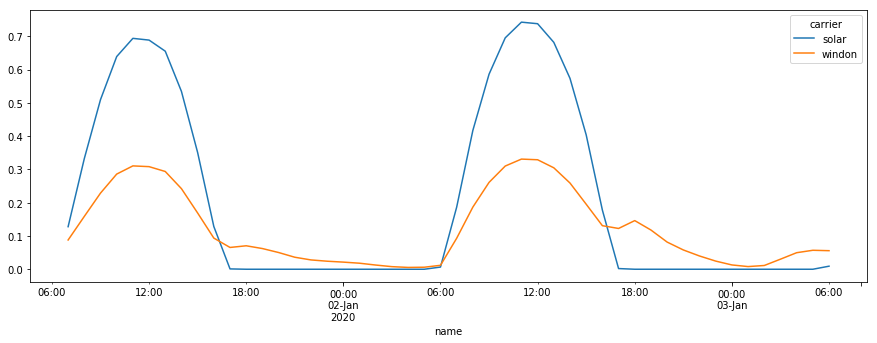

In [31]:
fig, ax = plt.subplots(figsize=(15,5))

network.generators_t.p_max_pu.groupby([network.generators.carrier], axis=1).mean().iloc[0:48] \
       .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).drop(columns='hydro').plot(ax=ax)

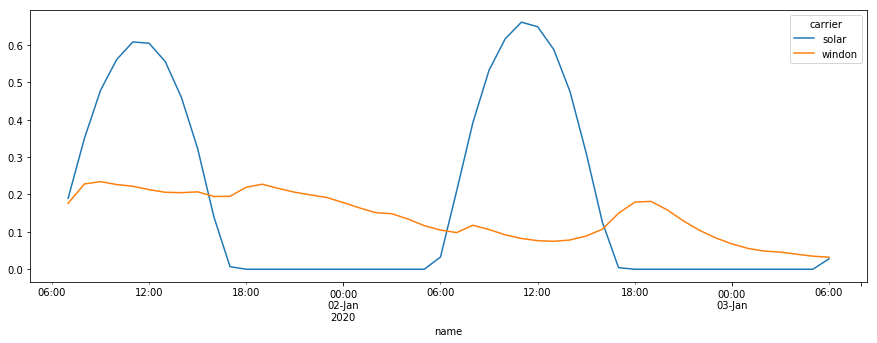

In [32]:
fig, ax = plt.subplots(figsize=(15,5))

ninja.generators_t.p_max_pu.groupby([ninja.generators.carrier], axis=1).mean().iloc[0:48] \
     .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).plot(ax=ax)

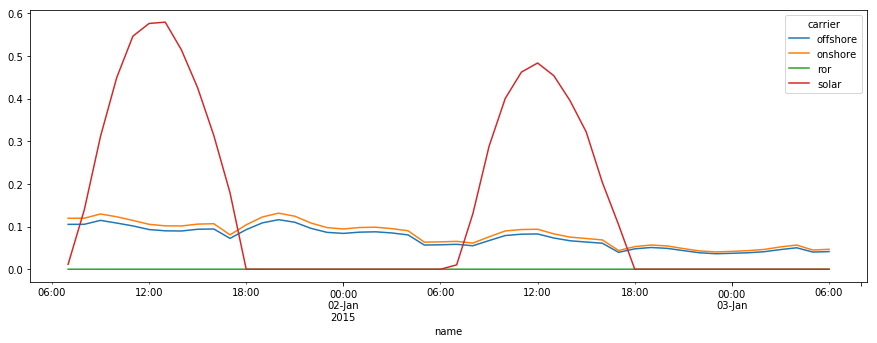

In [33]:
fig, ax = plt.subplots(figsize=(15,5))

era5.generators_t.p_max_pu.groupby([era5.generators.carrier], axis=1).mean().iloc[0:48] \
    .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).plot(ax=ax)

In [34]:
era5.add("GlobalConstraint","co2_limit",sense="<=",constant=1) #constraint for CO2 emission limit
era5.loads_t.p_set = era5.loads_t.p_set.fillna(0.)

In [74]:
#runlopf
era5.generators.loc[era5.generators.carrier=='hydro', 'p_nom_extendable'] = False
era5.generators.loc[era5.generators.carrier=='hydro', 'p_nom_max'] = 0.0
era5.global_constraints.loc['co2_limit','constant'] = 1e4
era5.lines['capital_cost'] = era5.lines['length'] * 100
era5.lopf(era5.snapshots[:100],solver_name='gurobi',keep_files=False,solver_options={'threads':8}) #full year

INFO:pypsa.pf:Slack bus for sub-network 0 is CongThanh
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x32266_copy
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 24202
  Number of variables: 32266
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 32266
  Number of nonzeros: 79701
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to o

('ok', 'optimal')

(<matplotlib.collections.PatchCollection at 0x7fb4d3988550>,
 <matplotlib.collections.LineCollection at 0x7fb4d2ef1690>)

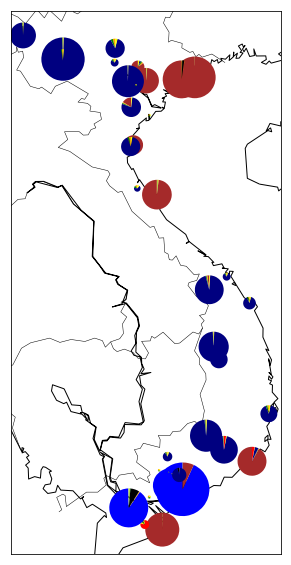

In [64]:
capas = era5.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = era5.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)

capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]

plotcapas = capas
plotlines = lines

fig, ax = plt.subplots(1,1, figsize=(10,10))

bus_scale = 1e4
link_scale = 1e2

colors = dict(zip(['wind', 'bioenergy', 'oil', 'gas', 'hard coal', 'offshore','onshore','ror','solar'],
                  ['red', 'lightgreen', 'black', 'blue', 'brown', 'orange','green','navy','yellow']))

era5.plot(bus_sizes=plotcapas/bus_scale, bus_colors=colors, ax=ax,
             line_widths={'Link':0.0, 'Line':plotlines/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'})

In [75]:
era5.lines

b        bus0        bus1  capital_cost   length          r  \
name                                                                       
1     0.672611    LaiChauH       SonLa       15850.0  158.500   4.390450   
2     0.678849     LaiChau       SonLa       15997.0  159.970   4.431169   
3     0.006238     LaiChau    LaiChauH         147.0    1.470   0.040719   
4     0.020369      SonLaH       SonLa         480.0    4.800   0.132960   
5     1.123281       SonLa     HiepHoa       26470.0  264.700   7.332190   
6     0.768092       SonLa     VietTri       18100.0  181.000   5.013700   
7     0.394655     VietTri     HiepHoa        9300.0   93.000   2.576100   
8     0.874182       SonLa    LaiChauH       20600.0  206.000   5.706200   
9     0.874182      SonLaH     NhoQuan       20600.0  206.000   5.706200   
10    0.874182     HoaBinh     NhoQuan       20600.0  206.000   5.706200   
11    0.318270     NhoQuan   ThuongTin        7500.0   75.000   2.077500   
12    0.169744    TayHaNoi   ThuongTin        4000.0   40.000   1.108000   
13    0.145131   ThuongTin      PhoNoi        3420.0   34.200   0.947340   
14    0.097603     HiepHoa     DongAnh        2300.0   23.000   0.637100   
15    0.094208     DongAnh      PhoNoi        2220.0   22.200   0.614940   
16    0.301296      PhoNoi     HiepHoa        7100.0   71.000   1.966700   
17    0.564399    NamDinh1      PhoNoi       13300.0  133.000   3.684100   
18    0.599621     HiepHoa   QuangNinh       14130.0  141.300   3.914010   
19    0.581373      PhoNoi   QuangNinh       13700.0  137.000   3.794900   
20    0.543181  ThangLongT      PhoNoi       12800.0  128.000   3.545600   
21    0.080628  ThangLongT   QuangNinh        1900.0   19.000   0.526300   
22    0.106090   QuangNinh  MongDuong1        2500.0   25.000   0.692500   
23    0.106090   QuangNinh  MongDuong2        2500.0   25.000   0.692500   
24    0.504988     NhoQuan     NghiSon       11900.0  119.000   3.296300   
25    0.042436   CongThanh     NghiSon        1000.0   10.000   0.277000   
26    0.797797     NghiSon      HaTinh       18800.0  188.000   5.207600   
27    0.297052     VungAng      HaTinh        7000.0   70.000   1.939000   
28    1.667735      HaTinh      DaNang       39300.0  393.000  10.886100   
29    1.502234     VungAng      DaNang       35400.0  354.000   9.805800   
30    0.458309      DaNang      DocSoi       10800.0  108.000   2.991600   
...        ...         ...         ...           ...      ...        ...   
36    1.222157      Pleiku     DakNong       28800.0  288.000   7.977600   
37    1.324003      Pleiku      DiLinh       31200.0  312.000   8.642400   
38    1.762579     Pleiku2     CauBong       41535.0  415.350  11.505195   
39    1.450590     Pleiku2   ChonThanh       34183.0  341.830   9.468691   
40    0.755361     DakNong     CauBong       17800.0  178.000   4.930600   
41    0.827502    VanPhong     VinhTan       19500.0  195.000   5.401500   
42    0.483770   ChonThanh       CuChi       11400.0  114.000   3.157800   
43    0.538937   ChonThanh      DucHoa       12700.0  127.000   3.517900   
44    0.305539      DucHoa       CuChi        7200.0   72.000   1.994400   
45    0.311989   ChonThanh     CauBong        7352.0   73.520   2.036504   
46    0.097603      DucHoa     CauBong        2300.0   23.000   0.637100   
47    0.127308     CauBong      PhuLam        3000.0   30.000   0.831000   
48    0.097603      DucHoa      PhuLam        2300.0   23.000   0.637100   
49    0.080289     CauBong     TanDinh        1892.0   18.920   0.524084   
50    0.742630      DiLinh     TanDinh       17500.0  175.000   4.847500   
51    0.997246     VinhTan     SongMay       23500.0  235.000   6.509500   
52    1.090605     VinhTan     TanUyen       25700.0  257.000   7.118900   
53    0.093359     SongMay     TanUyen        2200.0   22.000   0.609400   
54    0.142161   LongThanh     SongMay        3350.0   33.500   0.927950   
55    0.279653     SongMay       PhuMy        6590.0   65.900

In [76]:
era5.objective

0.0